<a href="https://colab.research.google.com/github/roeegro/Applied-Data-Science-Capstone-Course/blob/main/Segmentation_and_clustering_of_neighboarhoods_in_haifa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We want to test the feasibility of starting a big business of some type in Haifa. Haifa is heterogenous city, it has different neighborhoods differ by culture, economic level, the nature of the neighborhood and the residents. Starting a business may be a good choice in some neighborhood while it might not be the same in other place. We want to build a model that takes all neighborhoods, divides them to some clusters of similar neighborhoods and by this division to see which neighborhoods are fit to an entrepreneur's goals. The assumption of my research is the fact that the answer whatever to start a new business or not will be the same for other similar neighborhood. It is important to note that the answer for the asked question is binary – yes or no, and there is no measure of the probability that the business will succeed or not.

Let's import and save some global information that we should use later

In [1]:
!pip install bs4
from bs4 import BeautifulSoup
import pandas as pd
from sklearn.cluster import KMeans
import requests

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# set number of clusters
import numpy as np
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# module for calculate distances between 2 geolocations.
!pip install haversine
import haversine as hs
from haversine import Unit

/bin/bash: conda: command not found
/bin/bash: conda: command not found


Definition of my foursquare details in order to use its API

In [2]:
CLIENT_ID = 'WRPJCDJVVHL1LU3U10LE4SOJPZO1HVJSXK00R2GNO150W3PU' # My Foursquare ID
CLIENT_SECRET = 'UESUV112ILZANAYVRP3ORJNZLKGZWANTUZJTLGE41GSVUVCE' # My Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

Let's start with mining the names of the neighborhoods in Haifa

In [3]:
neighborhoods_url = 'https://en.wikipedia.org/wiki/Neighborhoods_of_Haifa'
response = requests.get(neighborhoods_url)
soup = BeautifulSoup(response.content,'html.parser')
content=soup.find(id="mw-content-text")
bolts = content.findAll('li')
neighborhoods = [bolt.get_text() for bolt in bolts]
neighborhoods.remove('Ramat Alon') #It's neseccary since there is another place with same geolocation

The following cell extracts the geolocation of each neighborhood

In [4]:
# The following function gets an address and returns its coordinates
def get_coordinates(address):
    geolocator = Nominatim(user_agent="haifa_explorer")
    location = geolocator.geocode(address)
    try:
        latitude = location.latitude
        longitude = location.longitude
    except:
        latitude = None
        longitude = None
    return latitude,longitude
        

latitudes = list()
longitudes = list()
i = 0
while i < len(neighborhoods):
    latitude,longitude = get_coordinates(neighborhoods[i] + ', Haifa')
    if latitude is None or longitude is None: # if geolocation is not available.
        neighborhoods.remove(neighborhoods[i])
    else:
        latitudes = latitudes + [latitude]
        longitudes = longitudes + [longitude]
        i = i + 1

# Store all the collected data in Pandas DataFrame object.
neighborhoods_df = pd.DataFrame(data={'Neighborhood':neighborhoods,'Latitude':latitudes,'Longitude':longitudes})
neighborhoods_df.head()

,Neighborhood,Latitude,Longitude
0,Bat Galim,32.832986,34.979331
1,Kiryat Eliezer,32.826464,34.978718
2,Kiryat Eliyahu,32.824606,34.986615
3,Hadar HaCarmel,32.811280,34.997113
4,Merkaz HaCarmel (Carmel Center),32.804678,34.987909


In [5]:
# create map of Haifa using latitude and longitude values
haifa_latitude, haifa_longitude = get_coordinates('Haifa')
map_haifa = folium.Map(location=[haifa_latitude, haifa_longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(neighborhoods_df['Latitude'], neighborhoods_df['Longitude'], neighborhoods_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_haifa)  
    
map_haifa

Based on my knowledge and the map, I will edit the wrong locations of some neighborhoods in Haifa, and will insert some neighborhoods which may be important for the analysis and does not appear in the url

In [6]:
def edit_latitude_and_longtitude(df,neighborhood,latitude,longtitude):
    row = df.loc[df['Neighborhood'] == neighborhood]
    index = row.index
    df.iloc[index, df.columns.get_loc('Latitude')] = latitude
    df.iloc[index, df.columns.get_loc('Longitude')] = longtitude
    

In [7]:
edit_latitude_and_longtitude(neighborhoods_df,'Ein HaYam',32.824485, 34.962175)
edit_latitude_and_longtitude(neighborhoods_df,'Ramat Remez',32.779576, 35.009248)
edit_latitude_and_longtitude(neighborhoods_df,'Kiryat Shmuel',32.840269, 35.070430)
edit_latitude_and_longtitude(neighborhoods_df,'Kiryat Haim',32.821481, 35.069877)


ramat_shaul = {'Neighborhood':'Ramat Shaul', 'Latitude':32.822354, 'Longitude':34.970138}
kiryat_shprintzak = {'Neighborhood':'kiryat shprintzak', 'Latitude':32.821494, 'Longitude':34.961120}
neve_david = {'Neighborhood':'neve david', 'Latitude':32.809119, 'Longitude':34.960439}
mtm = {'Neighborhood':'MTM - Merkat Ta\'asiot Mada (Science Industries Center)', 'Latitude':32.786973, 'Longitude':34.959181}
hod_hacarmel = {'Neighborhood':'Hod HaCarmel ', 'Latitude':32.766577, 'Longitude':34.988619}
downtown = {'Neighborhood':'Downtown ', 'Latitude':32.818916, 'Longitude':34.999672}
new_neighborhoods = [ramat_shaul,kiryat_shprintzak,neve_david,mtm,hod_hacarmel,downtown]
for new_neighborhood in new_neighborhoods:
    neighborhoods_df = neighborhoods_df.append(new_neighborhood, ignore_index=True)
neighborhoods_df

,Neighborhood,Latitude,Longitude
0,Bat Galim,32.832986,34.979331
1,Kiryat Eliezer,32.826464,34.978718
2,Kiryat Eliyahu,32.824606,34.986615
3,Hadar HaCarmel,32.811280,34.997113
4,Merkaz HaCarmel (Carmel Center),32.804678,34.987909
5,Carmel Ma'aravi (Western Carmel),32.809747,34.973503
6,Ramat HaTishbi,32.814316,34.977787
7,Stella Maris,32.820826,34.979774
8,Neve Sha'anan,32.787396,35.018903
9,Neve Yosef,32.791486,35.021323


Let's show all the updated neighborhoods locations

In [8]:
map_haifa = folium.Map(location=[haifa_latitude, haifa_longitude], zoom_start=10)
# add markers to map
for lat, lng, neighborhood in zip(neighborhoods_df['Latitude'], neighborhoods_df['Longitude'], neighborhoods_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_haifa)  
    
map_haifa

Let's calculate distance between the centers of the neighborhoods to prevent duplicates of POIs as many as possible

In [9]:
def get_coordinate(neighborhood):
  row = neighborhoods_df.loc[neighborhoods_df['Neighborhood'] == neighborhood]
  index = row.index
  return float(neighborhoods_df['Latitude'][index]),float(neighborhoods_df['Longitude'][index])

all_neighborhoods = neighborhoods_df['Neighborhood'].to_list()
distance_df = pd.DataFrame(columns=all_neighborhoods,index=all_neighborhoods)
for src_neighborhood in distance_df.index:
    for dest_neighborhood in distance_df.columns:
      first_poi = get_coordinate(src_neighborhood)
      second_poi = get_coordinate(dest_neighborhood) 
      distance = hs.haversine(first_poi,second_poi,Unit.METERS)
      distance_df[dest_neighborhood][src_neighborhood] = float(distance)
distance_df

,Bat Galim,Kiryat Eliezer,Kiryat Eliyahu,Hadar HaCarmel,Merkaz HaCarmel (Carmel Center),Carmel Ma'aravi (Western Carmel),Ramat HaTishbi,Stella Maris,Neve Sha'anan,Neve Yosef,Vardiya,Ramat Almogi,Ramat Alon South,Ramat Golda,Ramat Remez,Ein HaYam,Ramat Eshkol,Halisa,Wadi Nisnas,Wadi Salib,German Colony,Kiryat Haim,Kiryat Shmuel,Kababir,Romema,Shambur,Neve Paz,Ramat Shaul,kiryat shprintzak,neve david,MTM - Merkat Ta'asiot Mada (Science Industries Center),Hod HaCarmel,Downtown
Bat Galim,0,727.466,1153.88,2930.27,3248.19,2640.84,2081.05,1352.78,6275.05,6057.6,4594.59,6633.91,7002.37,6914.94,6564.21,1860.91,6004.41,4437.36,2294.08,3590,1673.1,8556.67,8549.71,3195.32,5587.34,4732.92,5478.89,1461.3,2127.96,3187.39,5451.95,7435.2,2461.77
Kiryat Eliezer,727.466,0,766.192,2409.4,2570.24,1921.7,1353.63,634.64,5742.54,5566.04,3943.94,5973.24,6387,6248.32,5943.45,1561.41,5285.64,3920.6,1825.74,3084.75,1278.81,8536,8705.18,2475.43,4911.6,4018.79,5009.47,922.87,1734.81,2576.37,4755.71,6723.12,2130.26
Kiryat Eliyahu,1153.88,766.192,0,1777.13,2219.24,2057.03,1410.61,765.049,5121.17,4907.62,3501.32,5542.59,5869.66,5830.63,5435.66,2283.71,5067.2,3283.58,1141.47,2436.38,534.721,7788.01,8022.42,2569.24,4523.27,3784.82,4333.51,1559.85,2407.3,2991.49,4907.65,6455.28,1374.43
Hadar HaCarmel,2930.27,2409.4,1777.13,0,1130.87,2213.03,1837.33,1937.03,3346.85,3156.66,1907.67,3893.69,4126.48,4193.56,3703.31,3579.85,3793.97,1513.83,655.55,676.097,1284.86,6893.76,7571.22,2422.28,2966.04,2591.17,2605.98,2805.45,3550.09,3435.79,4458.14,5033.75,882.138
Merkaz HaCarmel (Carmel Center),3248.19,2570.24,2219.24,1130.87,0,1459.56,1429.44,1949.88,3476.47,3450.49,1399.45,3406.13,3880.27,3678.58,3430.68,3261.01,2871.8,1901,1474.13,1396.65,1917.51,7884.77,8667.34,1454.54,2341.85,1599.02,3025.64,2573.17,3124.72,2614.37,3329.58,4237.14,1927.46
Carmel Ma'aravi (Western Carmel),2640.84,1921.7,2057.03,2213.03,1459.56,0,646.825,1364.22,4917.69,4909.12,2733.46,4569.74,5182.92,4804.52,4734.8,1951,3535.34,3346.89,2107.09,2727.34,2120.12,9100.21,9671.93,554.513,3473.45,2352.6,4480.89,1436.71,1745.11,1222.92,2864.38,5003.91,2649.56
Ramat HaTishbi,2081.05,1353.63,1410.61,1837.33,1429.44,646.825,0,747.337,4871.18,4795.93,2821.57,4785.12,5304.94,5042.83,4854.82,1845.81,3952.61,3168.36,1581.18,2442.44,1496.69,8642.44,9124.77,1168.34,3696.71,2703.17,4312.32,1144.48,1750.12,1721.15,3502.58,5404,2108.14
Stella Maris,1352.78,634.64,765.049,1937.03,1949.88,1364.22,747.337,0,5214.63,5071.72,3336.32,5355.99,5796.73,5627.73,5350.48,1694.09,4652.75,3419.54,1445.67,2607.97,1069.9,8419.96,8741.98,1906.64,4287.6,3384.41,4537.54,916.322,1744.7,2226.96,4227.77,6088.59,1871.48
Neve Sha'anan,6275.05,5742.54,5121.17,3346.85,3476.47,4917.69,4871.18,5214.63,0,508.023,2259.47,1966.66,1367.8,2187.09,1253.27,6717,3426.61,1838.81,3983.01,2686.43,4611.69,6087.87,7599.55,4765.05,2199.29,3256.67,1018.44,5990.2,6598.61,5974.62,5583.02,3657.18,3938.91
Neve Yosef,6057.6,5566.04,4907.62,3156.66,3450.49,4909.12,4795.93,5071.72,508.023,0,2375.81,2434.47,1875.81,2670.62,1740.15,6634.83,3785.63,1652.17,3766.61,2481.55,4384.87,5631.71,7105.17,4813.03,2521.75,3464.27,610.739,5887.68,6541.54,6018.9,5830.55,4125.51,3660.24


Take the minimum distance between 2 neighborhoods

In [10]:
[distance_df[col].astype('float') for col in distance_df.columns] #make all values converted to float
for area in distance_df.columns:
  distance_df[area][area] = distance_df[area].max()
mins = distance_df.min().to_list()
mins.sort()
radius = int(mins[4]) # I don't take the min in order to prevent missing of POIs

Let's write some functions that will scrap the data location of all business in Haifa.
For this purpose we will use 2 sources: OpenStreetMap (osm) and FourSquare - both have huge databases contains locations of businesses in Haifa

In [11]:
def get_nearby_venues_with_foursquare(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
def get_nearby_venues_with_osm(names, latitudes, longitudes, radius=500):
  venues_list = list()
  for name, lat, lng in zip(names, latitudes, longitudes):
    overpass_url = "http://overpass-api.de/api/interpreter"
    overpass_query = """
    [out:json];
    (
    node(around:{}.0,{}, {});
    );
    out body;
        """.format(radius,lat,lng)
    try:
      response = requests.get(overpass_url,
                              params={'data': overpass_query})
      data = response.json()
      nodes = data['elements']
      for node in nodes:
        try:
          venue_latitude = node['lat']
          venue_longitudes = node['lon']
          try:
            venue = node['tags']['name:en']
          except:
            venue = node['tags']['name']
          venue_category = node['tags']['amenity']
          new_venue = [name,lat,lng,venue,venue_latitude,venue_longitudes,venue_category]
          venues_list.append(new_venue)
          k = data
        except:
          continue
    except:
      continue
  nearby_venues = pd.DataFrame(venues_list)
  nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
  return nearby_venues

In [13]:
haifa_venues_by_foursquare = get_nearby_venues_with_foursquare(neighborhoods_df['Neighborhood'],
                                   neighborhoods_df['Latitude'],
                                   neighborhoods_df['Longitude'],radius)


haifa_venues_by_foursquare


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bat Galim,32.832986,34.979331,Bat Galim Beach,32.834930,34.977958,Beach
1,Bat Galim,32.832986,34.979331,Hofit,32.833825,34.976861,Ice Cream Shop
2,Bat Galim,32.832986,34.979331,Bat Galim Train Station,32.830411,34.982084,Train Station
3,Bat Galim,32.832986,34.979331,Dolphin (דולפין),32.832667,34.977972,Seafood Restaurant
4,Bat Galim,32.832986,34.979331,מסעדג,32.833743,34.976565,Seafood Restaurant
...,...,...,...,...,...,...,...
258,Downtown,32.818916,34.999672,Haifa Center Train Station (תחנת רכבת חיפה מרכ...,32.822362,34.997154,Train Station
259,Downtown,32.818916,34.999672,Yan Yan (יאן יאן),32.819165,34.998730,Chinese Restaurant
260,Downtown,32.818916,34.999672,1926 Designed Apartments Hotel,32.818278,34.999563,Hotel
261,Downtown,32.818916,34.999672,Cremerie De L’eclair,32.819873,34.998447,Ice Cream Shop


In [14]:
haifa_venues_by_osm = get_nearby_venues_with_osm(names=neighborhoods_df['Neighborhood'],
                                                 latitudes=neighborhoods_df['Latitude'],
                                                 longitudes=neighborhoods_df['Longitude'],
                                                 radius=radius)
haifa_venues_by_osm

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bat Galim,32.832986,34.979331,Paz,32.830046,34.978273,fuel
1,Bat Galim,32.832986,34.979331,Aliya,32.831884,34.981904,school
2,Bat Galim,32.832986,34.979331,Bat Galim train station,32.830555,34.982355,bus_station
3,Bat Galim,32.832986,34.979331,Delek,32.830241,34.977513,fuel
4,Bat Galim,32.832986,34.979331,Paz,32.830349,34.977003,fuel
...,...,...,...,...,...,...,...
249,Downtown,32.818916,34.999672,Jungle,32.819502,34.999239,cafe
250,Downtown,32.818916,34.999672,After Dark,32.819143,34.997973,bar
251,Downtown,32.818916,34.999672,Peter's,32.819666,34.996654,pub
252,Downtown,32.818916,34.999672,Margalet & Mayo,32.819857,34.995891,bureau_de_change


Let's combine the information from the sources above and remove duplicates

In [15]:
def remove_duplicates(venues_df,minum_distance = 100):
  cleaned_venues_df = venues_df.copy()
  indexes_to_remove = set()
  for index,row in cleaned_venues_df.iterrows():
    if index in indexes_to_remove:
      continue
    venue_neighborhood = row['Neighborhood']
    venue_neighborhood_lat = row['Neighborhood Latitude']
    venue_neighborhood_lng = row['Neighborhood Longitude']
    src_neighborhood_geoloc = (venue_neighborhood_lat,venue_neighborhood_lng)
    venue_name = row['Venue']
    venue_lat = row['Venue Latitude']
    venue_lng = row['Venue Longitude']
    src_geoloc = (venue_lat,venue_lng)
    duplicates_df = cleaned_venues_df.loc[cleaned_venues_df['Venue'] == venue_name]
    index_list =duplicates_df.index.to_list()
    index_list.remove(index)
    duplicates_df =  duplicates_df.loc[index_list,:]
    distances = list()
    for index1,row1 in duplicates_df.iterrows():
      distances = distances +  [hs.haversine((row1['Venue Latitude'],row1['Venue Longitude']),src_geoloc,Unit.METERS)]
    duplicates_df['distance from src'] = distances
    duplicates_df = duplicates_df.loc[duplicates_df['distance from src'] < minum_distance]
    
    # keep indexes to remove
    
    # check duplicates in the same neighborhood
    duplicates_in_same_neighborhood_indexes = set(duplicates_df.loc[duplicates_df['Neighborhood']==venue_neighborhood].index.to_list())
    duplicates_df.drop(duplicates_in_same_neighborhood_indexes)
    indexes_to_remove = indexes_to_remove.union(duplicates_in_same_neighborhood_indexes)
    
    # for duplicates detected from 2 different neighborhoods - remove the record with the farest neighborhood
    distances_from_neighborhood = list()
    for index1,row1 in duplicates_df.iterrows():
      distances_from_neighborhood = distances_from_neighborhood +  [hs.haversine((row1['Venue Latitude'],row1['Venue Longitude']),(row1['Neighborhood Latitude'],row1['Neighborhood Longitude']),Unit.METERS)]
    duplicates_df['distances from neighborhood'] = distances_from_neighborhood
    distance_of_src_from_src_neighborhood = hs.haversine((row['Venue Latitude'],row['Venue Longitude']),src_neighborhood_geoloc)
    distances_by_index = [(index1,row1['distances from neighborhood']) for index1,row1 in duplicates_df.iterrows()] + [(index,distance_of_src_from_src_neighborhood)]
    distances = [distance for (index,distance) in distances_by_index]
    min_distance_index = distances_by_index[distances.index(min(distances))][0]
    indexes = [index for (index,distance) in distances_by_index]
    indexes.remove(min_distance_index)
    indexes_to_remove = indexes_to_remove.union(set(indexes))

  cleaned_venues_df = cleaned_venues_df.drop(indexes_to_remove).reset_index()
  return cleaned_venues_df


haifa_venues = haifa_venues_by_osm.append(haifa_venues_by_foursquare, ignore_index=True)
cleaned_venues_df = remove_duplicates(haifa_venues)
cleaned_venues_df

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Bat Galim,32.832986,34.979331,Paz,32.830046,34.978273,fuel
1,1,Bat Galim,32.832986,34.979331,Aliya,32.831884,34.981904,school
2,2,Bat Galim,32.832986,34.979331,Bat Galim train station,32.830555,34.982355,bus_station
3,3,Bat Galim,32.832986,34.979331,Delek,32.830241,34.977513,fuel
4,4,Bat Galim,32.832986,34.979331,Paz,32.830349,34.977003,fuel
...,...,...,...,...,...,...,...,...
433,512,Downtown,32.818916,34.999672,Haifa Center Train Station (תחנת רכבת חיפה מרכ...,32.822362,34.997154,Train Station
434,513,Downtown,32.818916,34.999672,Yan Yan (יאן יאן),32.819165,34.998730,Chinese Restaurant
435,514,Downtown,32.818916,34.999672,1926 Designed Apartments Hotel,32.818278,34.999563,Hotel
436,515,Downtown,32.818916,34.999672,Cremerie De L’eclair,32.819873,34.998447,Ice Cream Shop


Let's get some statistics to look if there are places with less information. First, we will count how many POI there are in each neighborhood

In [16]:
number_of_venues_by_neighborhood = cleaned_venues_df.groupby(by='Neighborhood').size().to_frame('count').reset_index().sort_values(by='count',ascending=False)
number_of_venues_by_neighborhood

,Neighborhood,count
14,Merkaz HaCarmel (Carmel Center),70
2,Downtown,62
4,German Colony,47
29,Wadi Nisnas,43
5,Hadar HaCarmel,32
0,Bat Galim,19
26,Shambur,17
16,Neve Sha'anan,16
11,Kiryat Haim,10
30,Wadi Salib,10


[]

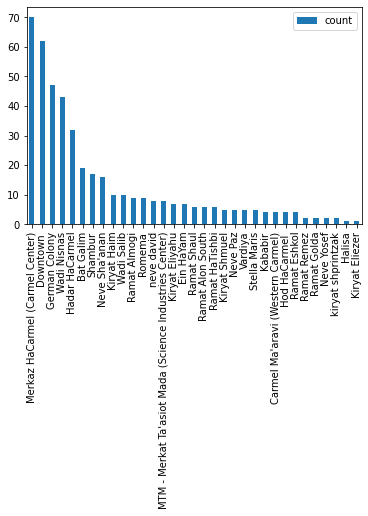

In [31]:
ax = number_of_venues_by_neighborhood.plot.bar()
ax.set_xticklabels(number_of_venues_by_neighborhood['Neighborhood'].to_list())
ax.plot()

Based on my knowledge - Foursquare and OpenStreetMap have more knowledge on commercial areas then residential neighborhoods (All the areas that has more business are actually commercial). Let's filter some areas with less data

In [17]:
most_popular_neighborhoods = number_of_venues_by_neighborhood[number_of_venues_by_neighborhood['count'] > number_of_venues_by_neighborhood['count'].median()]
indexes_to_look_for = most_popular_neighborhoods.index

In [18]:
most_popular_neighborhoods

,Neighborhood,count
14,Merkaz HaCarmel (Carmel Center),70
2,Downtown,62
4,German Colony,47
29,Wadi Nisnas,43
5,Hadar HaCarmel,32
0,Bat Galim,19
26,Shambur,17
16,Neve Sha'anan,16
11,Kiryat Haim,10
30,Wadi Salib,10


Let's take the POIs located in the popular neighborhoods

In [19]:
venues_filtered = cleaned_venues_df.loc[cleaned_venues_df['Neighborhood'].isin(most_popular_neighborhoods['Neighborhood'])].set_index('index')
venues_filtered

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
index,,,,,,,
0,Bat Galim,32.832986,34.979331,Paz,32.830046,34.978273,fuel
1,Bat Galim,32.832986,34.979331,Aliya,32.831884,34.981904,school
2,Bat Galim,32.832986,34.979331,Bat Galim train station,32.830555,34.982355,bus_station
3,Bat Galim,32.832986,34.979331,Delek,32.830241,34.977513,fuel
4,Bat Galim,32.832986,34.979331,Paz,32.830349,34.977003,fuel
...,...,...,...,...,...,...,...
512,Downtown,32.818916,34.999672,Haifa Center Train Station (תחנת רכבת חיפה מרכ...,32.822362,34.997154,Train Station
513,Downtown,32.818916,34.999672,Yan Yan (יאן יאן),32.819165,34.998730,Chinese Restaurant
514,Downtown,32.818916,34.999672,1926 Designed Apartments Hotel,32.818278,34.999563,Hotel


Let's prepare our data for the model. First, let's encode the venue's categories with 1-hot vector encoding.

In [20]:
haifa_venues_onehot = pd.get_dummies(venues_filtered[['Venue Category']], prefix="", prefix_sep="")
haifa_venues_onehot['Neighborhood'] = venues_filtered['Neighborhood']
haifa_venues_onehot

,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Bakery,Bar,Basketball Court,Beach,Bed & Breakfast,Bistro,Breakfast Spot,Burger Joint,Bus Station,Bus Stop,Café,Caribbean Restaurant,Chinese Restaurant,Coffee Shop,Concert Hall,Convenience Store,Drugstore,Duty-free Shop,Eastern European Restaurant,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Food & Drink Shop,Food Truck,French Restaurant,Gastropub,Grocery Store,Gym,Gym / Fitness Center,Hostel,Hotel,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Market,Mediterranean Restaurant,...,Plaza,Pub,Restaurant,Sandwich Place,Science Museum,Seafood Restaurant,Shawarma Place,Shopping Mall,Snack Place,Steakhouse,Supermarket,Tapas Restaurant,Theater,Train Station,Zoo,atm,bank,bar,bureau_de_change,bus_station,cafe,cinema,clinic,community_centre,dentist,embassy,fast_food,fuel,gym,kindergarten,nightclub,parking,pharmacy,place_of_worship,preschool,pub,restaurant,school,taxi,theatre
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
513,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
514,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Let's see how many business of some type there are in the neighborhoods

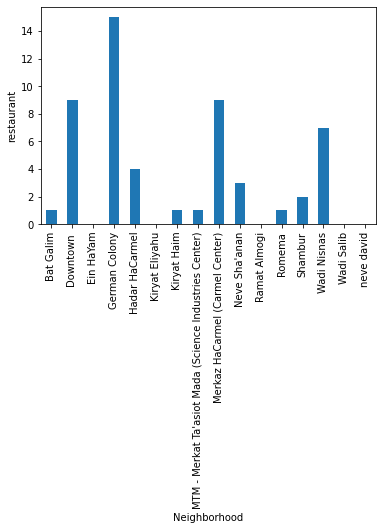

In [58]:
def business_for_some_type_per_neigh(one_hot_repr_df,business_type):
  one_hot_repr_grouped_df = haifa_venues_normalized = one_hot_repr_df.groupby('Neighborhood').sum()
  count_business_type_per_neigh = one_hot_repr_grouped_df[business_type]
  ax = count_business_type_per_neigh.plot.bar()
  ax.set_ylabel(business_type)
  ax.plot()

business_for_some_type_per_neigh(haifa_venues_onehot,'restaurant')

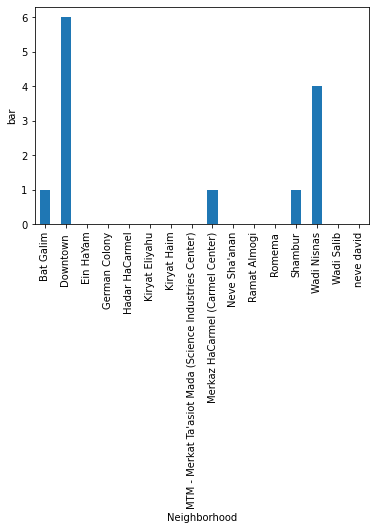

In [60]:
business_for_some_type_per_neigh(haifa_venues_onehot,'bar')

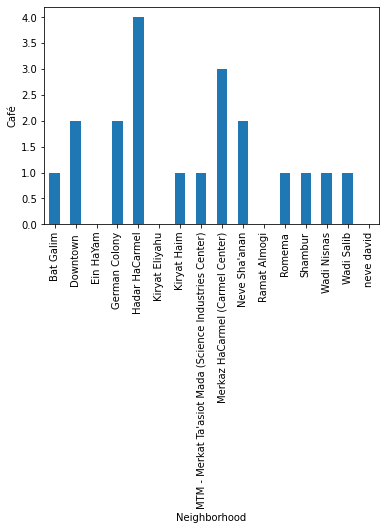

In [64]:
business_for_some_type_per_neigh(haifa_venues_onehot,'Café')

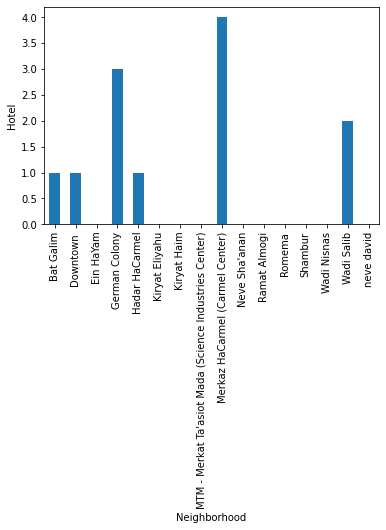

In [61]:
business_for_some_type_per_neigh(haifa_venues_onehot,'Hotel')

Our next step will be to group the POIs by neighborhoods and normalize the data

In [21]:
haifa_venues_normalized = haifa_venues_onehot.groupby('Neighborhood').mean()
haifa_venues_normalized

,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Bakery,Bar,Basketball Court,Beach,Bed & Breakfast,Bistro,Breakfast Spot,Burger Joint,Bus Station,Bus Stop,Café,Caribbean Restaurant,Chinese Restaurant,Coffee Shop,Concert Hall,Convenience Store,Drugstore,Duty-free Shop,Eastern European Restaurant,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Food & Drink Shop,Food Truck,French Restaurant,Gastropub,Grocery Store,Gym,Gym / Fitness Center,Hostel,Hotel,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Market,Mediterranean Restaurant,...,Plaza,Pub,Restaurant,Sandwich Place,Science Museum,Seafood Restaurant,Shawarma Place,Shopping Mall,Snack Place,Steakhouse,Supermarket,Tapas Restaurant,Theater,Train Station,Zoo,atm,bank,bar,bureau_de_change,bus_station,cafe,cinema,clinic,community_centre,dentist,embassy,fast_food,fuel,gym,kindergarten,nightclub,parking,pharmacy,place_of_worship,preschool,pub,restaurant,school,taxi,theatre
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Bat Galim,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.105263,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.052632,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.052632,0.052632,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.105263,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.052632,0.000000,0.00000,0.000000,0.052632,0.000000,0.052632,0.052632,0.0000,0.000000,0.000,0.000000,0.000000,0.000000,0.157895,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.052632,0.052632,0.000000,0.0
Downtown,0.000000,0.000000,0.000000,0.016129,0.016129,0.032258,0.000000,0.000000,0.00000,0.016129,0.000000,0.000000,0.016129,0.000000,0.032258,0.000000,0.016129,0.000000,0.000000,0.000000,0.000,0.016129,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.016129,0.000000,0.000000,0.000,0.000000,0.000000,0.016129,0.016129,0.016129,0.00000,0.000000,0.000000,...,0.016129,0.032258,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.016129,0.000000,0.016129,0.00000,0.016129,0.000000,0.00000,0.032258,0.096774,0.000000,0.000000,0.145161,0.0000,0.000000,0.000,0.000000,0.000000,0.112903,0.016129,0.000000,0.000000,0.000000,0.000000,0.000000,0.032258,0.000,0.000000,0.145161,0.048387,0.016129,0.0
Ein HaYam,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.285714,0.00000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.142857,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.0
German Colony,0.000000,0.000000,0.000000,0.021277,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.021277,0.000000,0.000000,0.000000,0.042553,0.021277,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.042553,0.00000,0.000000,0.000000,0.021277,0.000000,0.000,0.000000,0.000000,0.063830,0.021277,0.000000,0.00000,0.000000,0.021277,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.021277,0.000000,0.021277,0.000000,0.042553,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.021277,0.000000,0.127660,0.0000,0.000000,0.000,0.000000,0.000000,0.063830,0.000000,0.000000,0.000000,0.000000,0.000000,0.021277,0.000000,0.000,0.000000,0.319149,0.021277,0.000000,0.0
Hadar HaCarmel,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031250,0.03125,0.000000,0.0312

We will use clustering model to get the neighborhoods grouped to 2 sets - areas with leisure and cultural areas and the others.

In [22]:
kclusters = 2

# haifa_neighborhoods_normalized = haifa_venues_normalized.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(haifa_venues_normalized)

# add clustering labels
haifa_venues_normalized['Cluster Labels'] =  kmeans.labels_
haifa_venues_normalized_with_neighborhood_geoloc =haifa_venues_normalized.merge(neighborhoods_df,how='inner',on='Neighborhood')
haifa_venues_normalized_with_neighborhood_geoloc

,Neighborhood,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Bakery,Bar,Basketball Court,Beach,Bed & Breakfast,Bistro,Breakfast Spot,Burger Joint,Bus Station,Bus Stop,Café,Caribbean Restaurant,Chinese Restaurant,Coffee Shop,Concert Hall,Convenience Store,Drugstore,Duty-free Shop,Eastern European Restaurant,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Food & Drink Shop,Food Truck,French Restaurant,Gastropub,Grocery Store,Gym,Gym / Fitness Center,Hostel,Hotel,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Market,...,Sandwich Place,Science Museum,Seafood Restaurant,Shawarma Place,Shopping Mall,Snack Place,Steakhouse,Supermarket,Tapas Restaurant,Theater,Train Station,Zoo,atm,bank,bar,bureau_de_change,bus_station,cafe,cinema,clinic,community_centre,dentist,embassy,fast_food,fuel,gym,kindergarten,nightclub,parking,pharmacy,place_of_worship,preschool,pub,restaurant,school,taxi,theatre,Cluster Labels,Latitude,Longitude
0,Bat Galim,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.105263,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.052632,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.052632,0.052632,0.000000,0.00000,0.000000,...,0.000000,0.00000,0.105263,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.052632,0.000000,0.00000,0.000000,0.052632,0.000000,0.052632,0.052632,0.0000,0.000000,0.000,0.000000,0.000000,0.000000,0.157895,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.052632,0.052632,0.000000,0.0,1,32.832986,34.979331
1,Downtown,0.000000,0.000000,0.000000,0.016129,0.016129,0.032258,0.000000,0.000000,0.00000,0.016129,0.000000,0.000000,0.016129,0.000000,0.032258,0.000000,0.016129,0.000000,0.000000,0.000000,0.000,0.016129,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.016129,0.000000,0.000000,0.000,0.000000,0.000000,0.016129,0.016129,0.016129,0.00000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.016129,0.000000,0.016129,0.00000,0.016129,0.000000,0.00000,0.032258,0.096774,0.000000,0.000000,0.145161,0.0000,0.000000,0.000,0.000000,0.000000,0.112903,0.016129,0.000000,0.000000,0.000000,0.000000,0.000000,0.032258,0.000,0.000000,0.145161,0.048387,0.016129,0.0,0,32.818916,34.999672
2,Ein HaYam,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.285714,0.00000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.142857,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.0,1,32.824485,34.962175
3,German Colony,0.000000,0.000000,0.000000,0.021277,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.021277,0.000000,0.000000,0.000000,0.042553,0.021277,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.042553,0.00000,0.000000,0.000000,0.021277,0.000000,0.000,0.000000,0.000000,0.063830,0.021277,0.000000,0.00000,0.000000,...,0.000000,0.00000,0.021277,0.000000,0.021277,0.000000,0.042553,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.021277,0.000000,0.127660,0.0000,0.000000,0.000,0.000000,0.000000,0.063830,0.000000,0.000000,0.000000,0.000000,0.000000,0.021277,0.000000,0.000,0.000000,0.319149,0.021277,0.000000,0.0,0,32.821702,34.991176
4,Hadar HaCarmel,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031250,0.03125,0.000000,0.031250,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.03

Let's set color scheme for the clusters and use markers to show each match between neighborhood to its cluster.

In [23]:
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]



map_haifa = folium.Map(location=[haifa_latitude, haifa_longitude], zoom_start=10)
# add markers to map
for lat, lon, poi, cluster in zip(haifa_venues_normalized_with_neighborhood_geoloc['Latitude'], haifa_venues_normalized_with_neighborhood_geoloc['Longitude'], haifa_venues_normalized_with_neighborhood_geoloc['Neighborhood'],haifa_venues_normalized_with_neighborhood_geoloc['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_haifa) 
    
map_haifa

As shown above, the clustering model divides the areas to 2 clusters. In red - areas with with leisure and cultural areas, where its more recommended to start a new business in, and other areas which is less recommended. Based on my knowledge, I can say that the model built accurate clusters.